In [1]:
"""Compute depth maps for images in the input folder.
"""
import os
os.chdir('../pyCarDisplay/detection/')
import glob
import torch
#import utils
import cv2
import argparse
from PIL import Image
import numpy as np
from torchvision.transforms import Compose
from midas.midas_net import MidasNet
from midas.midas_net_custom import MidasNet_small
from midas.transforms import Resize, NormalizeImage, PrepareForNet
def run(pil_image, output_path, model_path, model_type="large", optimize=True):
    """Run MonoDepthNN to compute depth maps.

    Args:
        input_path (str): path to input folder
        output_path (str): path to output folder
        model_path (str): path to saved model
    """
    #print("initialize")

    # select device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #print("device: %s" % device)

    # load network
    if model_type == "large":
        model = MidasNet(model_path, non_negative=True)
        net_w, net_h = 384, 384
    elif model_type == "small":
        model = MidasNet_small(model_path, features=64, backbone="efficientnet_lite3", exportable=True, non_negative=True, blocks={'expand': True})
        net_w, net_h = 256, 256
    else:
        print(f"model_type '{model_type}' not implemented, use: --model_type large")
        assert False
    
    transform = Compose(
        [
            Resize(
                net_w,
                net_h,
                resize_target=None,
                keep_aspect_ratio=True,
                ensure_multiple_of=32,
                resize_method="upper_bound",
                image_interpolation_method=cv2.INTER_CUBIC,
            ),
            NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            PrepareForNet(),
        ]
    )

    model.eval()
    
    if optimize==True:
        rand_example = torch.rand(1, 3, net_h, net_w)
        model(rand_example)
        traced_script_module = torch.jit.trace(model, rand_example)
        model = traced_script_module
    
        if device == torch.device("cuda"):
            model = model.to(memory_format=torch.channels_last)  
            model = model.half()

    model.to(device)

    # get input
    #img_names = glob.glob(os.path.join(input_path, "*"))
    num_images = 1 #len(img_names)

    # create output folder
    os.makedirs(output_path, exist_ok=True)

    #print("start processing")

    #for ind, img_name in enumerate(img_names):

        #print("  processing {} ({}/{})".format(img_name, ind + 1, num_images))

        # input

        #img = utils.read_image(img_name)
    # use numpy to convert the pil_image into a numpy array
    pil_image=np.array(pil_image)

    # convert to a openCV2 image, notice the COLOR_RGB2BGR which means that 
    # the color is converted from RGB to BGR format
    #img=cv2.cvtColor(numpy_image, cv2.COLOR_RGB2BGR)
    img_input = transform({"image": pil_image})["image"]

    # compute
    with torch.no_grad():
        sample = torch.from_numpy(img_input).to(device).unsqueeze(0)
        if optimize==True and device == torch.device("cuda"):
            sample = sample.to(memory_format=torch.channels_last)  
            sample = sample.half()
        prediction = model.forward(sample)
        prediction = (
            torch.nn.functional.interpolate(
                prediction.unsqueeze(1),
                size=pil_image.shape[:2],
                mode="bicubic",
                align_corners=False,
            )
            .squeeze()
            .cpu()
            .numpy()
        )

    # output
    #filename = os.path.join(
    #    output_path, os.path.splitext(os.path.basename(img_name))[0]
    #)
    #return_val = utils.write_depth(img_input, prediction, bits=2)
    
    #color_coverted = cv2.cvtColor(img_input, cv2.COLOR_BGR2RGB)
    #pil_image=Image.fromarray(color_coverted)

    #print("finished")
    return prediction

In [2]:
img_file = '../../data/0000000005.png'
image = run(pil_image=Image.open(img_file), model_type='large', model_path='../../data/model-f6b98070.pt', optimize=
            False, output_path='output')

Loading weights:  ../../data/model-f6b98070.pt


Using cache found in /Users/ckvarga/.cache/torch/hub/facebookresearch_WSL-Images_master


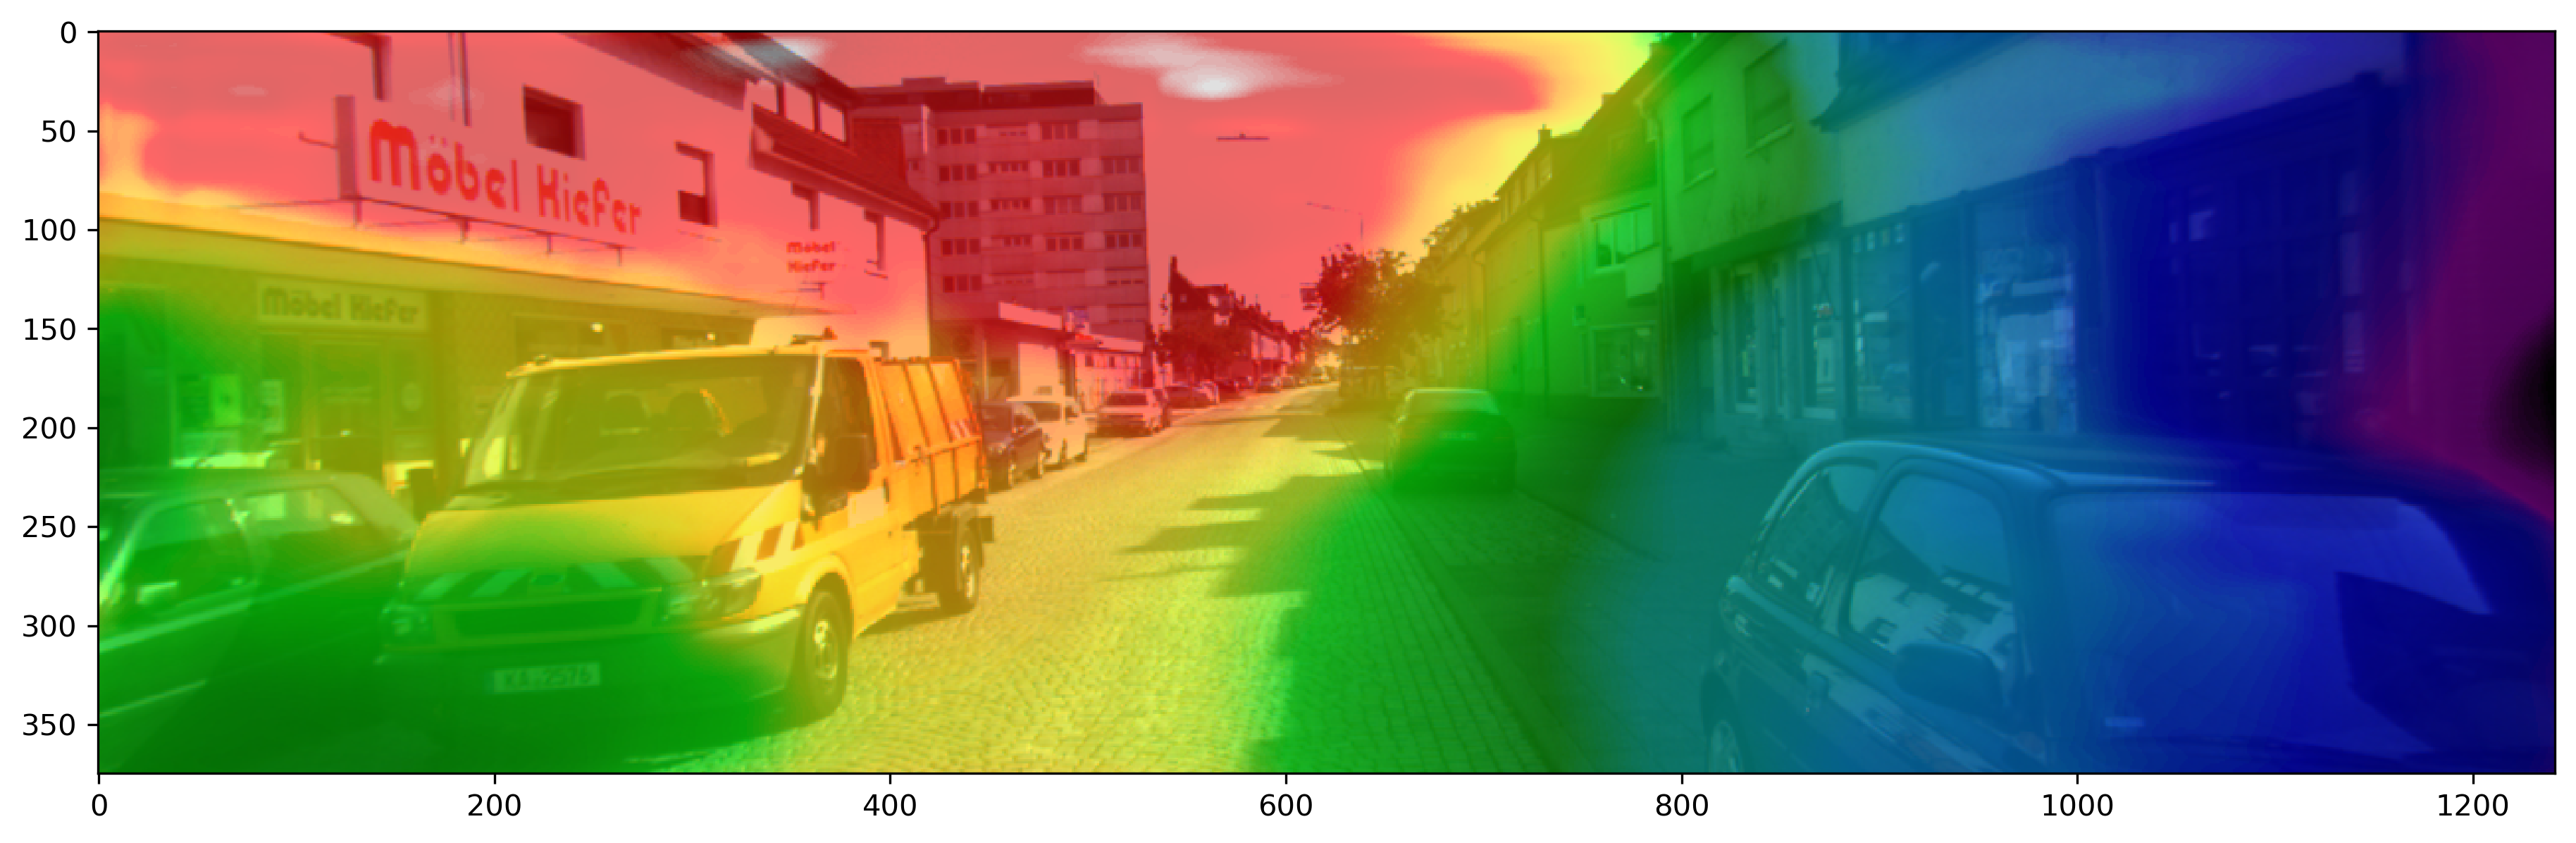

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image
#plt.figure(figsize=(15,8),dpi=300)
img = plt.imread(img_file)
fig, ax = plt.subplots(figsize=(15,8),dpi=300)
ax.imshow(img)
ax.imshow(image,alpha=0.6, cmap='nipy_spectral')
#imgplot = plt.imshow(image)#np.log2(image))
#imgplot.set_cmap('nipy_spectral')
#plt.colorbar()

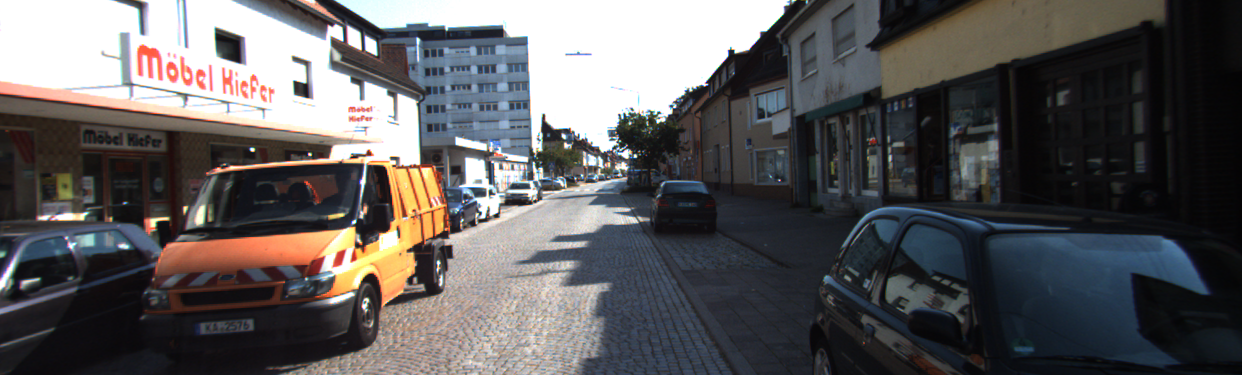

In [4]:
Image(filename=img_file)